## Grouping Telecom Base Stations Based on Proximity using Spatial Clustering ML techniques

The aim of this project was to divide 2764 Telecom base sites into groups of 15. This was used in planning the maintenance of the stations among the team of the clients Maintenance Engineers around the country. 

In [1]:
import pandas as pd
import geopandas as gpd
import codecs
from shapely.geometry import Point, LineString, Polygon

## Exploring the data
The data was provided in a CSV file with Some information on the Site ID and location of the stations. This contains 2764 Sites accross 4 major regions around the country

In [2]:
# Reading the data
mpi = pd.read_csv("MPI_sites.csv")
print(len(mpi))
mpi.head()

2764


,Site ID,Latitude,Longitude,Region IHS,State
0,IHS_ABE_001,7.13978,3.32859,Lagos,Ogun
1,IHS_ABE_002,7.16650,3.33967,Lagos,Ogun
2,IHS_ABE_003,7.18090,3.41183,Lagos,Ogun
3,IHS_ABE_004,7.18609,3.34841,Lagos,Ogun
4,IHS_ABE_005,7.14439,3.37381,Lagos,Ogun


In [3]:
# Renaming the Site ID column for easier access
mpi = mpi.rename(columns={'Site ID': 'Site_ID'})
mpi.to_csv("Mpi_Sites_1.csv", index = True)


### Creating Geodataframe
The geolocation were given as seperate value in Longitude and latitude columns. In order to perfom geospatial operations, a geometry column needs to be created. This is usually done by zipping the lat and lon and applying a point to it. Then creating a geodataframe using this new column as the geometry.

In [4]:
# Zipping the geometry in this case point geometry
mpi['geometry']  = list(zip(mpi['Longitude'], mpi['Latitude']))

#This applies point to the geometry
mpi['geometry'] = mpi['geometry'].apply(Point)

mpi = gpd.GeoDataFrame(mpi, geometry='geometry')
mpi.head()

,Site_ID,Latitude,Longitude,Region IHS,State,geometry
0,IHS_ABE_001,7.13978,3.32859,Lagos,Ogun,POINT (3.32859 7.13978)
1,IHS_ABE_002,7.16650,3.33967,Lagos,Ogun,POINT (3.33967 7.16650)
2,IHS_ABE_003,7.18090,3.41183,Lagos,Ogun,POINT (3.41183 7.18090)
3,IHS_ABE_004,7.18609,3.34841,Lagos,Ogun,POINT (3.34841 7.18609)
4,IHS_ABE_005,7.14439,3.37381,Lagos,Ogun,POINT (3.37381 7.14439)


### Visualization

This was done using matplotlib and contextily as basemap

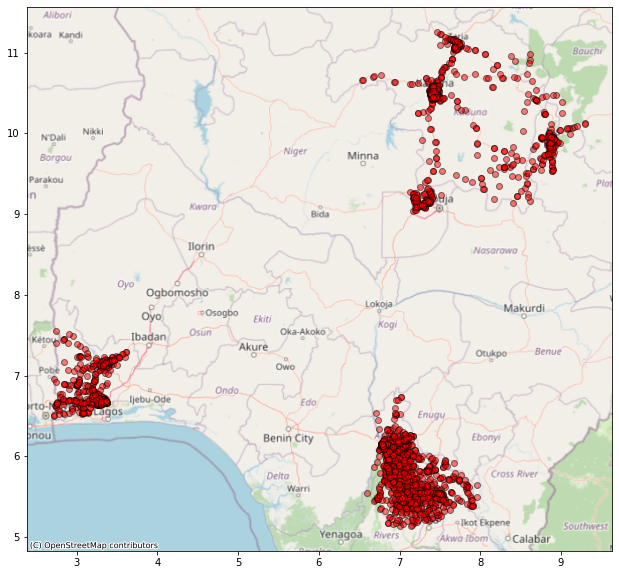

In [5]:
import contextily as ctx
import warnings
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
warnings.filterwarnings('ignore')

## Visualization
mpi.crs = {'init' :'epsg:4326'}

# we reproject to match contextility map
#mpi = mpi.to_crs({'init': 'epsg:3857'})
ax = mpi.plot(figsize=(15, 10), alpha=0.5, color = 'r', edgecolor='k')

#ctx.add_basemap(ax, url=ctx.providers.Esri.WorldImagery)

#ctx.add_basemap(ax)
#ax.set_axis_off()

# add open street map basemap
ctx.add_basemap(ax, crs = mpi.crs, url = ctx.providers.OpenStreetMap.Mapnik)

In [6]:
# Sorting the values
import numpy as np

sort_val = mpi.sort_values(by=['Longitude', 'Latitude'])

sorted_mpi = sort_val.reset_index(drop = True)
sorted_mpi.head()

,Site_ID,Latitude,Longitude,Region IHS,State,geometry
0,IHS_OGU_006,6.95827,2.71545,Lagos,Ogun,POINT (2.71545 6.95827)
1,IHS_LAG_170V,6.50590,2.71966,Lagos,Ogun,POINT (2.71966 6.50590)
2,T0876,6.50806,2.72389,Lagos,Ogun,POINT (2.72389 6.50806)
3,OG3275,6.63370,2.73460,Lagos,Ogun,POINT (2.73460 6.63370)
4,IHS_LAG_175V,6.63842,2.74296,Lagos,Ogun,POINT (2.74296 6.63842)


## Grouping of Clusters with Kmeans

Kmeans Clustering was used to cluster the data. This divides the data into 185 groups of unequal clusters (closest to each other). However the aim is to have equal clusters of 15 sites and maybe 1 cluster containing the remainder. 

In [7]:
from sklearn.cluster import KMeans
# cluster with Kmeans
km = KMeans(n_clusters=int(len(sorted_mpi)/15), random_state=5)
new = sorted_mpi._get_numeric_data().dropna(axis=1)
km.fit(new)
predict=km.predict(new)

In [8]:
# Assign the clusters to a new columnn 'Site group'
sorted_mpi['Site group'] = pd.Series(predict, index=sorted_mpi.index)
sorted_mpi

,Site_ID,Latitude,Longitude,Region IHS,State,geometry,Site group
0,IHS_OGU_006,6.95827,2.71545,Lagos,Ogun,POINT (2.71545 6.95827),143
1,IHS_LAG_170V,6.50590,2.71966,Lagos,Ogun,POINT (2.71966 6.50590),111
2,T0876,6.50806,2.72389,Lagos,Ogun,POINT (2.72389 6.50806),111
3,OG3275,6.63370,2.73460,Lagos,Ogun,POINT (2.73460 6.63370),111
4,IHS_LAG_175V,6.63842,2.74296,Lagos,Ogun,POINT (2.74296 6.63842),111
...,...,...,...,...,...,...,...
2759,IHS_BAU_028,10.06732,9.13260,Abuja,Bauchi,POINT (9.13260 10.06732),125
2760,B6124,10.08206,9.16547,Abuja,Bauchi,POINT (9.16547 10.08206),33
2761,T1431,10.09500,9.20389,Abuja,Bauchi,POINT (9.20389 10.09500),33
2762,B6125,10.12389,9.29948,Abuja,Bauchi,POINT (9.29948 10.12389),33


### Dividing Into Equal Clusters

In oder to get equal clusters, there is need to cut off the cluster numbering as soon as the number completes 15 and join the remaining to the next cliuster. Thes data was first sorted based on Region and the clustered site groups.

In [9]:
df = sorted_mpi.sort_values(['Region IHS','Site group'], ascending=[True,True])
df = df.reset_index(drop=True)
df.head()

,Site_ID,Latitude,Longitude,Region IHS,State,geometry,Site group
0,KD6279,10.54759,7.42772,Abuja,Kaduna,POINT (7.42772 10.54759),0
1,T1013,10.53889,7.44194,Abuja,Kaduna,POINT (7.44194 10.53889),0
2,IHS_KAD_026V,10.55574,7.44230,Abuja,Kaduna,POINT (7.44230 10.55574),0
3,B6058,10.54836,7.44345,Abuja,Kaduna,POINT (7.44345 10.54836),0
4,T1801,10.55000,7.44389,Abuja,Kaduna,POINT (7.44389 10.55000),0


The regions were put in a list

In [10]:
# Check the regions
regions = df["Region IHS"].unique()
regions      

array(['Abuja', 'Asaba', 'Enugu', 'Lagos'], dtype=object)

The grouping was done by subdividing the dataframe into regions and slicing the cluster in 15s, the last cluster is the only one that is allowed to be less than 15

In [11]:
# Creating an empty list
site_group = []
 
for j in range(len(regions)):
    
    # Subdividing inot rgions
    sub_df = df[df["Region IHS"]== regions[j]]
    
    # Defining size of cluster
    NROWS = 15
    
    #Cutting off clusters at 15 and assigning to a new colunm
    sub_df["site_group"] = np.repeat(range(0, int(np.ceil(sub_df.shape[0]/NROWS))), NROWS)[0: sub_df.shape[0]]
    
    # Extracting the ID and group
    sub_df = sub_df[["Site_ID", "site_group"]]
    
    # reindexing to start from 0
    sub_df = sub_df.reset_index(drop=True)
    
    # Appending the site_group value to the empty list 
    for i in range(len(sub_df)):
        site_group.append(sub_df["site_group"][i])
        
    #new_df = pd.merge(sub_df, df, on = 'Site ID', how ="right")
    #New_AP = pd.merge(AP, New_AP_matched, how="left", on=["OBJECTID"])
  

We create a copy of the dataframe and assign the extracted site group to a new colums, Site group 2

In [12]:
new_df = df
new_df["Site group 2"] = site_group
new_df["Site group 2"] = new_df["Site group 2"] + 1
new_df.head(50)

,Site_ID,Latitude,Longitude,Region IHS,State,geometry,Site group,Site group 2
0,KD6279,10.54759,7.42772,Abuja,Kaduna,POINT (7.42772 10.54759),0,1
1,T1013,10.53889,7.44194,Abuja,Kaduna,POINT (7.44194 10.53889),0,1
2,IHS_KAD_026V,10.55574,7.44230,Abuja,Kaduna,POINT (7.44230 10.55574),0,1
3,B6058,10.54836,7.44345,Abuja,Kaduna,POINT (7.44345 10.54836),0,1
4,T1801,10.55000,7.44389,Abuja,Kaduna,POINT (7.44389 10.55000),0,1
5,B6060,10.53757,7.44465,Abuja,Kaduna,POINT (7.44465 10.53757),0,1
6,IHS_KAD_003,10.55885,7.44626,Abuja,Kaduna,POINT (7.44626 10.55885),0,1
7,B6056,10.55867,7.44667,Abuja,Kaduna,POINT (7.44667 10.55867),0,1
8,T1168,10.57389,7.45000,Abuja,Kaduna,POINT (7.45000 10.57389),0,1
9,B4664,10.54280,7.45089,Abuja,Kaduna,POINT (7.45089 10.54280),0,1


When we compare these two Site groups, we can see that Site group 2 are of equal size unlike the first site group


We visualize this on a map for Enugu region

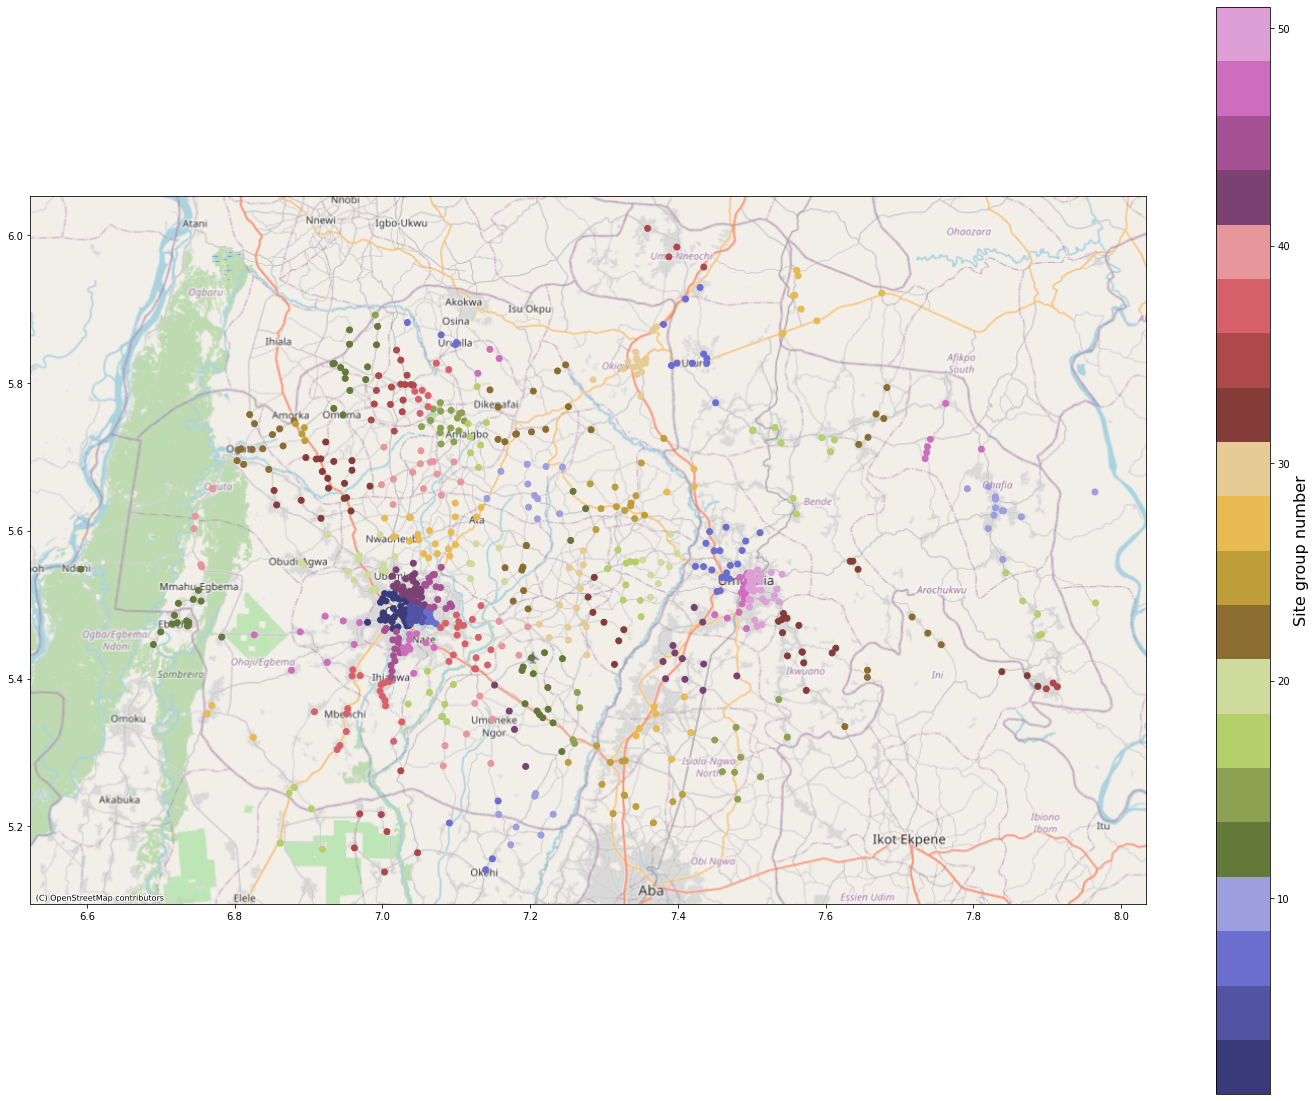

In [13]:
import matplotlib.colors as colors
sorted_mpi = new_df[new_df["Region IHS"]== "Enugu"]
norm = colors.Normalize(vmin= sorted_mpi["Site group 2"].min(), vmax=sorted_mpi["Site group 2"].max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='tab20b')
# we assign original CRS


fig, ax = plt.subplots(figsize=(25, 20))
# with no normalization
sorted_mpi.plot(column='Site group 2', cmap='tab20b', legend=False, ax=ax , alpha = 1.0)
# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Site group number', fontsize = 16)
ctx.add_basemap(ax, crs = mpi.crs, url = ctx.providers.OpenStreetMap.Mapnik)

We visualize this for the whole country

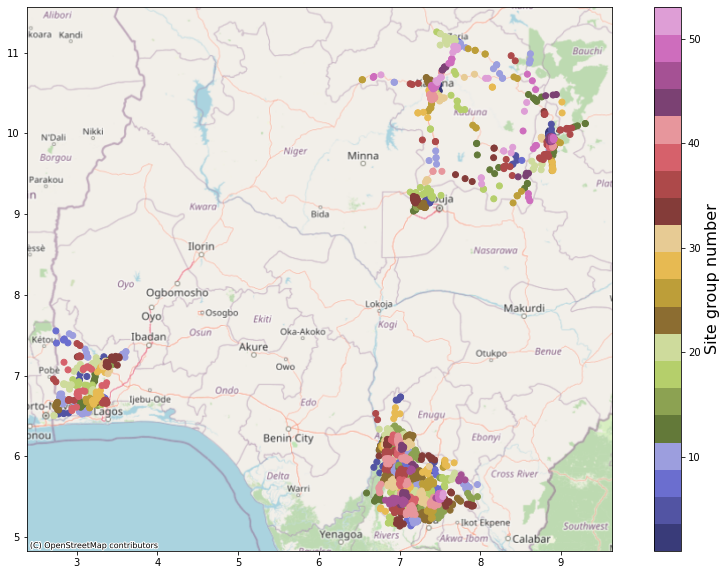

In [14]:
sorted_mpi = new_df
norm = colors.Normalize(vmin= sorted_mpi["Site group 2"].min(), vmax=sorted_mpi["Site group 2"].max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='tab20b')
# we assign original CRS


fig, ax = plt.subplots(figsize=(15, 10))
# with no normalization
sorted_mpi.plot(column='Site group 2', cmap='tab20b', legend=False, ax=ax , alpha = 1.0)
# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Site group number', fontsize = 16)
ctx.add_basemap(ax, crs = mpi.crs, url = ctx.providers.OpenStreetMap.Mapnik)

Plotting on Esri World Imagery basemap

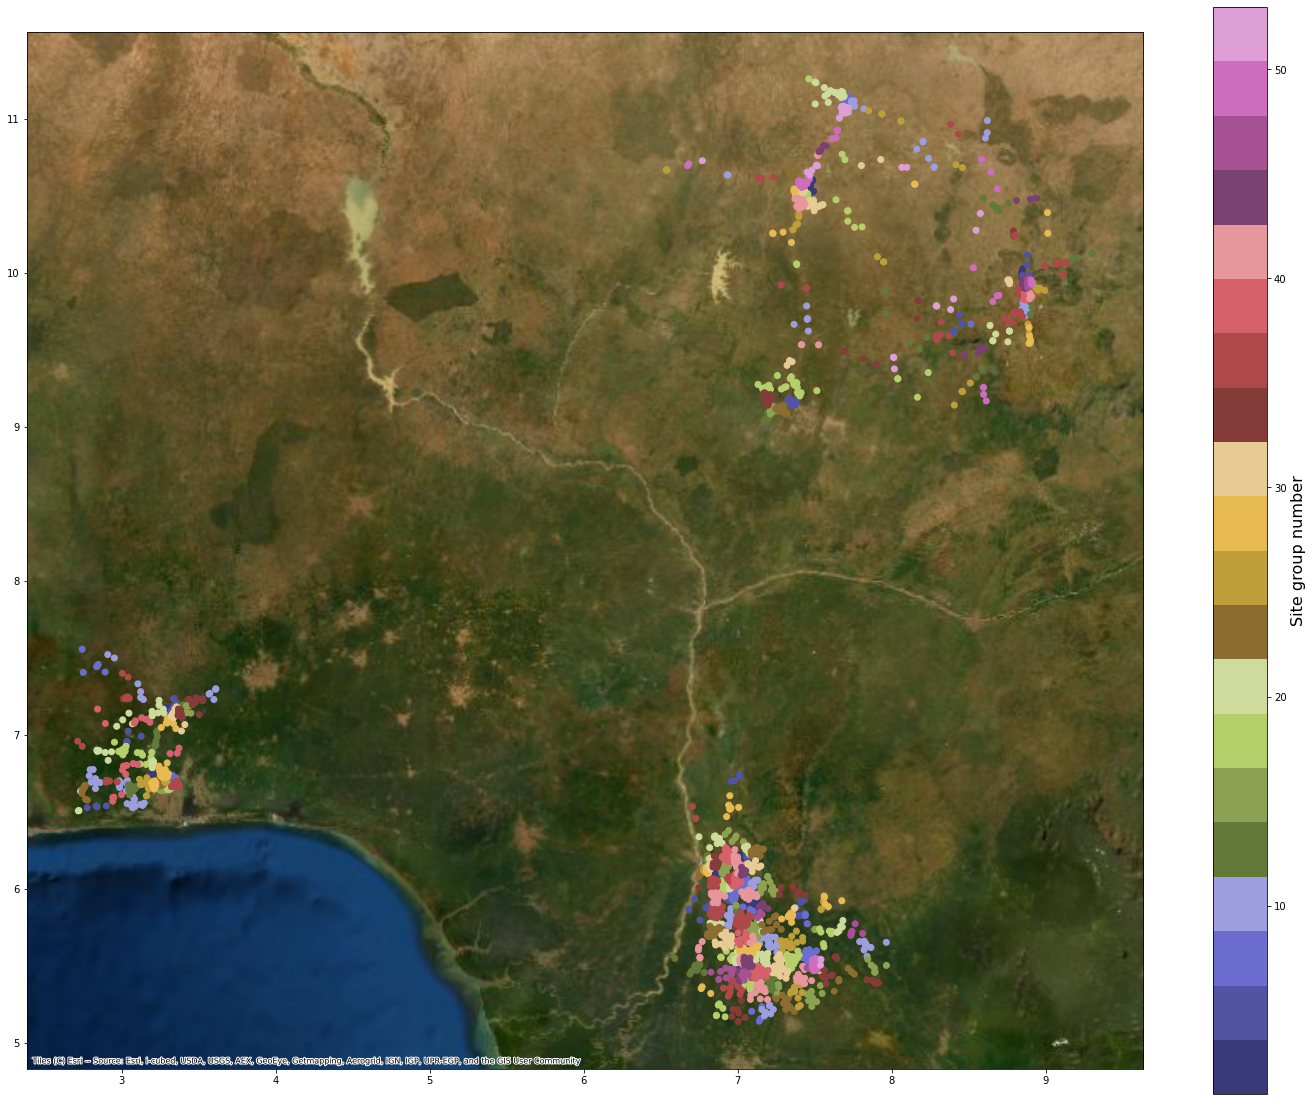

In [15]:
import contextily as ctx
import warnings
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
warnings.filterwarnings('ignore')

## Visualization
mpi = new_df

sorted_mpi = mpi#[mpi["Region IHS"]== "Enugu"]
#sorted_mpi = mpi
norm = colors.Normalize(vmin= sorted_mpi["Site group 2"].min(), vmax=sorted_mpi["Site group 2"].max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='tab20b')
# we assign original CRS


fig, ax = plt.subplots(figsize=(25, 20))
# with no normalization
sorted_mpi.plot(column='Site group 2', cmap='tab20b', legend=False, ax=ax , alpha = 1.0)
# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Site group number', fontsize = 16)
ctx.add_basemap(ax,crs = mpi.crs, url=ctx.providers.Esri.WorldImagery)

The clusters of 15 telecom sites each are clearly seen on the map